In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge

In [2]:
ixi_data_pth = "./data/ixi/IXI_crossval_vessel.csv"
ixi_df = pd.read_csv(ixi_data_pth)
ixi_df = ixi_df.dropna(subset=["age"])

In [3]:
vessel_features = ixi_df.columns[1:17]
vessel_features = vessel_features.drop('branch_list')
vessel_features = vessel_features.drop('radius_list')
vessel_features = vessel_features.drop('tortuosity_list')
vessel_features

Index(['num_branches', 'total_volume', 'bifurcations', 'endpoints',
       'mean_radius', 'max_radius', 'min_radius', 'mean_tortuosity',
       'max_tortuosity', 'min_tortuosity', 'total_branch_length',
       'mean_branch_length', 'max_branch_length'],
      dtype='object')

In [4]:
def get_formula(pred, features):
    formula = pred + ' ~ '
    for feature in features:
        formula += feature + ' + '
    return formula[:-3]

def fit_ols(df, pred, features):
    formula = get_formula(pred, features)
    model = sm.OLS.from_formula(formula, data=df)
    result = model.fit()
    return result

def k_fold_cross_validation(df, sub_id_col, target, features, k=10, return_models=False):
    kf = KFold(n_splits=k)
    predictions = pd.Series(index=df.index, dtype=float)
    models = []
    for train_index, test_index in kf.split(df):
        train = df.iloc[train_index]
        test = df.iloc[test_index]
        result = fit_ols(train, target, features)
        predictions.iloc[test_index] = result.predict(test)
        models.append(result)

    result_df = pd.DataFrame({
        'sub_id': df[sub_id_col],
        'target': df[target],
        'predicted': predictions,
        'dice': df['dice']
    })

    if return_models:
        return result_df, models
    else:
        return result_df

def k_fold_cross_validation_ridge(df, sub_id_col,
                                  target, features,
                                  k=10, return_models=False,
                                  alpha=1.0):
    kf = KFold(n_splits=k)
    predictions = pd.Series(index=df.index, dtype=float)
    models = []
    for train_index, test_index in kf.split(df):
        train = df.iloc[train_index]
        test = df.iloc[test_index]

        # Fit Ridge regression
        ridge = Ridge(alpha=alpha)
        ridge.fit(train[features], train[target])

        # Predict
        predictions.iloc[test_index] = ridge.predict(test[features])
        models.append(ridge)
    result_df = pd.DataFrame({
        'sub_id': df[sub_id_col],
        'target': df[target],
        'predicted': predictions,
        'dice': df['dice']
    })

    if return_models:
        return result_df, models
    else:
        return result_df

In [5]:
results_kfold, models = k_fold_cross_validation(ixi_df, 'sub_id', 'age', vessel_features, k=10, return_models=True)

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
font_size = 20
def plot_target_vs_predicted(df, target_col='target',
                             predicted_col='predicted',
                             xlabel='Actual Age',
                             ylabel='Predicted Age',
                             title='Actual Age vs Predicted Age',
                             save_path=None,
                             x_range=None,
                             y_range=None,
                             color_by='Dice'):
    r2score = r2_score(df[target_col], df[predicted_col])

    plt.figure(figsize=(10, 8))
    if x_range is not None:
        plt.xlim(x_range)
    if y_range is not None:
        plt.ylim(y_range)
    scatter = plt.scatter(df[target_col], df[predicted_col], alpha=0.5, c=df[color_by],
                          s=100)
    colorbar = plt.colorbar(scatter, label=color_by.capitalize())
    colorbar.ax.yaxis.label.set_size(font_size)
    colorbar.ax.yaxis.set_tick_params(labelsize=font_size)
    colorbar.ax.yaxis.set_label_position("left")
    plt.plot([10, 90],
             [10, 90],
             color='black', linestyle='--', linewidth=2)
    plt.xlabel(xlabel, fontsize=font_size)
    plt.ylabel(ylabel, fontsize=font_size)
    plt.title(title)
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

    # Add the R² score inside the plot
    plt.text(0.05, 0.95, f'R²: {r2score:.2f}', transform=plt.gca().transAxes,
             fontsize=font_size, verticalalignment='top')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds(10, 90)
    ax.spines['left'].set_bounds(10, 90)
    ax.set_xticks(np.arange(10, 100, 10))
    plt.tick_params(axis='x', labelsize=24)
    plt.tick_params(axis='y', labelsize=24)

    if save_path:
        plt.savefig(save_path)
    plt.show()
    return r2score

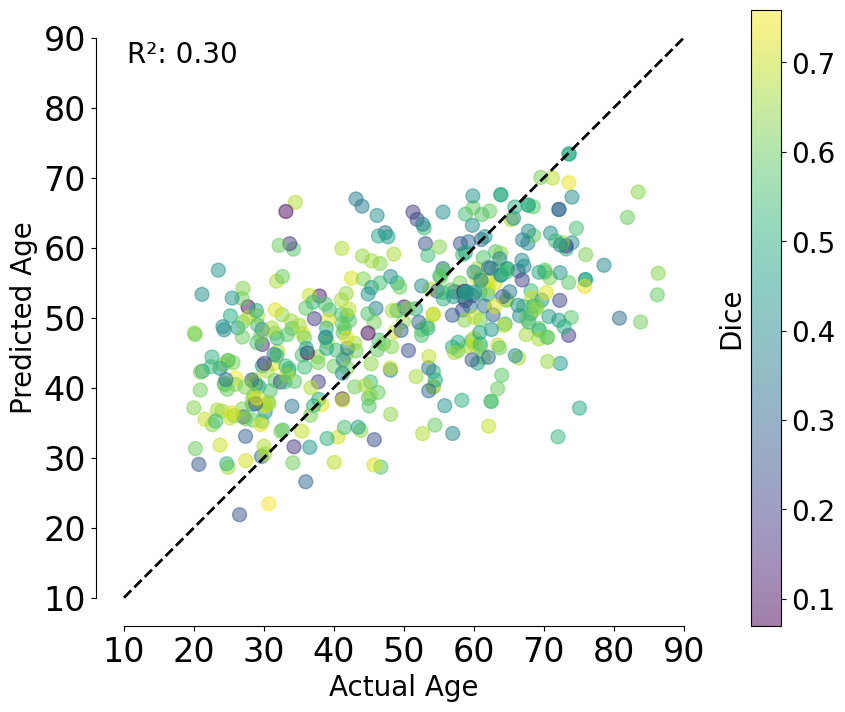

In [7]:
r2_score = plot_target_vs_predicted(results_kfold,
                                    color_by='dice',
                                    title='')